<a href="https://colab.research.google.com/github/ruqayya/Whole-Slide-Image-Registration/blob/main/Elastix_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimpleITK
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@dev-DFBRegistration | tail -n 1

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
  Running command git clone -q https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-y79_uv57
  Running command git checkout -b dev-DFBRegistration --track origin/dev-DFBRegistration
  Switched to a new branch 'dev-DFBRegistration'
  Branch 'dev-DFBRegistration' set up to track remote branch 'dev-DFBRegistration' from 'origin'.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


  "Metadata: Falling back to TIFF resolution tag"

  "Metadata: Objective power inferred from microns-per-pixel (MPP)."



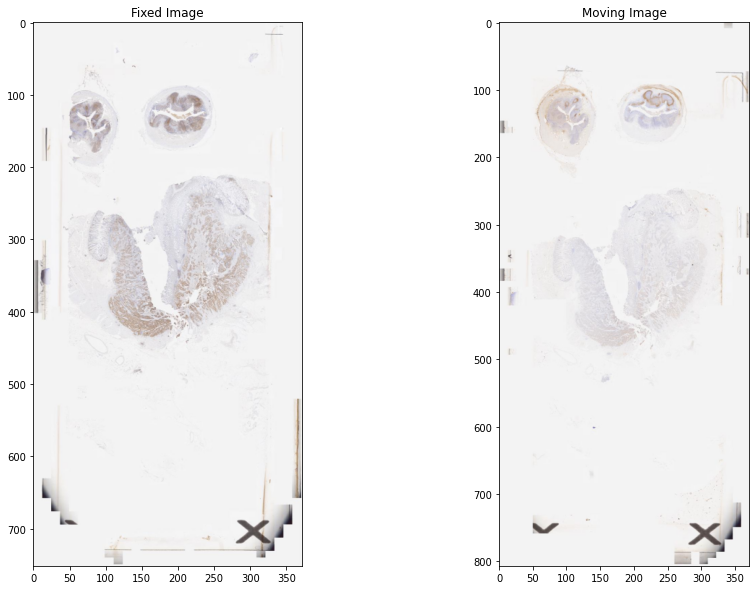

In [ ]:
from matplotlib import pyplot as plt
from tiatoolbox.wsicore.wsireader import WSIReader
import os
import pdb


main_path = '/content/gdrive/MyDrive/RegistrationData'
fixed_wsi_reader = WSIReader.open(input_img=os.path.join(main_path, 'Case2_Section1.tif'))
fixed_image = fixed_wsi_reader.slide_thumbnail(resolution=0.1563, units="power")
moving_wsi_reader = WSIReader.open(input_img=os.path.join(main_path, 'Case2_Section2.tif'))
moving_image = moving_wsi_reader.slide_thumbnail(resolution=0.1563, units="power")

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

**Image Pre-processing**

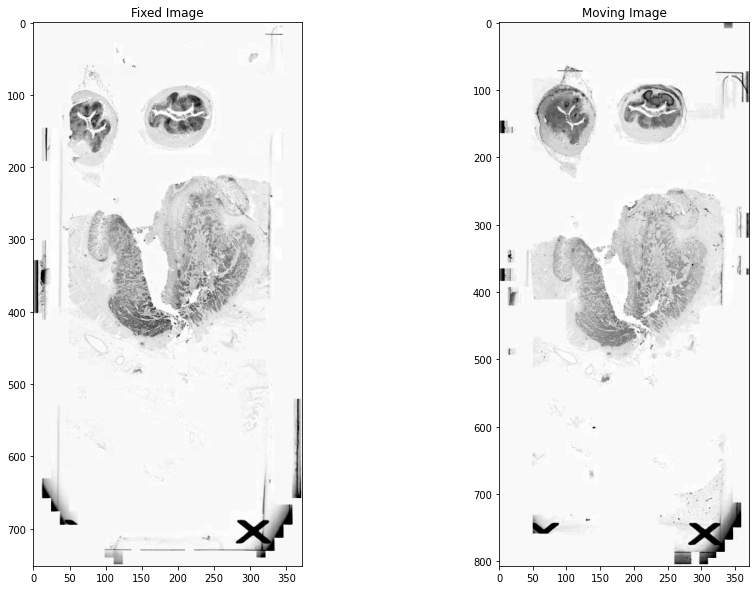

In [ ]:
from skimage import color, exposure
from tiatoolbox.tools.registration.wsi_registration import match_histograms
import numpy as np

def preprocess_image(image):
  image = color.rgb2gray(image)
  image = exposure.rescale_intensity(image, in_range=tuple(np.percentile(image, (0.5, 99.5))))
  image = image*255
  return image.astype(np.uint8)

fixed_image = preprocess_image(fixed_image)
moving_image = preprocess_image(moving_image)
fixed_image, moving_image = match_histograms(fixed_image, moving_image)

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

**Tissue Segmentation**

In [ ]:
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
import numpy as np
import cv2

# fixed_image = np.repeat(np.expand_dims(fixed_image, axis=2), 3, axis=2)
# cv2.imwrite(os.path.join(main_path, 'fixed.png'), fixed_image)
# moving_image = np.repeat(np.expand_dims(moving_image, axis=2), 3, axis=2)
# cv2.imwrite(os.path.join(main_path, 'moving.png'), moving_image)
# pdb.set_trace()

# perform segmentation
ioconfig = IOSegmentorConfig(
	input_resolutions=[
		{"units": "baseline", "resolution": 1.0},
	],
	output_resolutions=[
		{"units": "baseline", "resolution": 1.0},
	],
	patch_input_shape=[1024, 1024],
	patch_output_shape=[512, 512],
	stride_shape=[512, 512],
	save_resolution={"units": "baseline", "resolution": 1.0},
)

segmentor = SemanticSegmentor(
	pretrained_model="unet_tissue_mask_tsef",
	num_loader_workers=4,
	batch_size=4,
)

output = segmentor.predict(
  [os.path.join(main_path, 'fixed.png'), os.path.join(main_path, 'moving.png')],
	save_dir=os.path.join(main_path, 'tissue_mask'),
	mode="tile",
	on_gpu=False,
	ioconfig=ioconfig,
	crash_on_exception=True,
)

  "WSIPatchDataset only reads image tile at "



Download from https://tiatoolbox.dcs.warwick.ac.uk/models/registration/UNET-v0.0-TSEF.pth
Save to /root/.tiatoolbox/models/UNET-v0.0-TSEF.pth


  "WSIPatchDataset only reads image tile at "

  cpuset_checked))

  warnings.warn("Raw data is None")

  warnings.warn("Unknown scale (no objective_power or mpp)")

Process Batch: 100%|##############################| 1/1 [00:14<00:00, 14.27s/it]


**Post-processing of Mask**

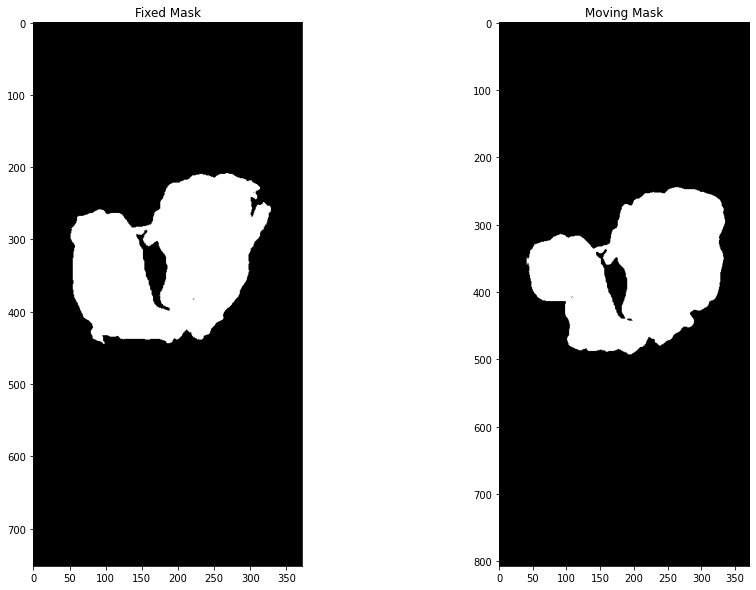

In [ ]:
from skimage import measure, morphology

def post_processing_mask(mask):
  # remove all the objects while keep the biggest object only
  label_img = measure.label(mask)
  regions = measure.regionprops(label_img)
  mask = mask.astype(bool)
  all_area = [i.area for i in regions]
  second_max = max([i for i in all_area if i != max(all_area)])
  mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
  return mask.astype(np.uint8)

fixed_mask = np.load(output[0][1] + ".raw.0.npy")[:, :, 2] > 0.5
moving_mask = np.load(output[1][1] + ".raw.0.npy")[:, :, 2] > 0.5
fixed_mask = post_processing_mask(fixed_mask)
moving_mask = post_processing_mask(moving_mask)

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_mask, cmap='gray')
axs[0].set_title("Fixed Mask")
axs[1].imshow(moving_mask, cmap='gray')
axs[1].set_title("Moving Mask")
plt.show()

**Pre-alignment**

[[  0.98480775  -0.17364818  57.8315722 ]
 [  0.17364818   0.98480775 -68.24317425]
 [  0.           0.           1.        ]]


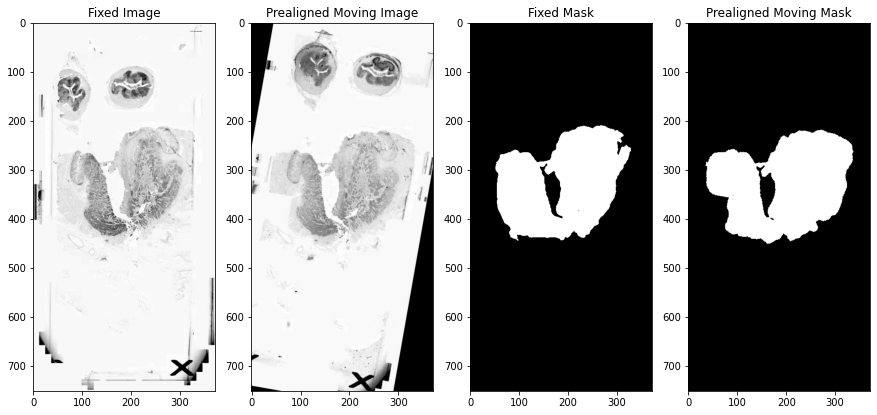

In [ ]:
from tiatoolbox.tools.registration.wsi_registration import prealignment

# pdb.set_trace()
pre_transform = prealignment(fixed_image[:,:,0], moving_image[:,:,0], fixed_mask, moving_mask)
print(pre_transform)
pre_registered_image = cv2.warpAffine(moving_image, pre_transform[0:-1][:], fixed_image.shape[:2][::-1]) # fixed_image_sitk.GetSize()
pre_registered_mask = cv2.warpAffine(moving_mask, pre_transform[0:-1][:], fixed_image.shape[:2][::-1]) # fixed_image_sitk.GetSize()
# pdb.set_trace()
_, axs = plt.subplots(1, 4, figsize=(15,10))
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(pre_registered_image, cmap='gray')
axs[1].set_title("Prealigned Moving Image")
axs[2].imshow(fixed_mask, cmap='gray')
axs[2].set_title("Fixed Mask")
axs[3].imshow(pre_registered_mask, cmap='gray')
axs[3].set_title("Prealigned Moving Mask")
plt.show()

# moving_image_sitk = sitk.GetImageFromArray(moving_image)

**DFBR**

  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[[ 9.98029756e-01  2.61299159e-04  2.24642562e-01]
 [-1.72785874e-03  9.97211997e-01  1.01505136e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


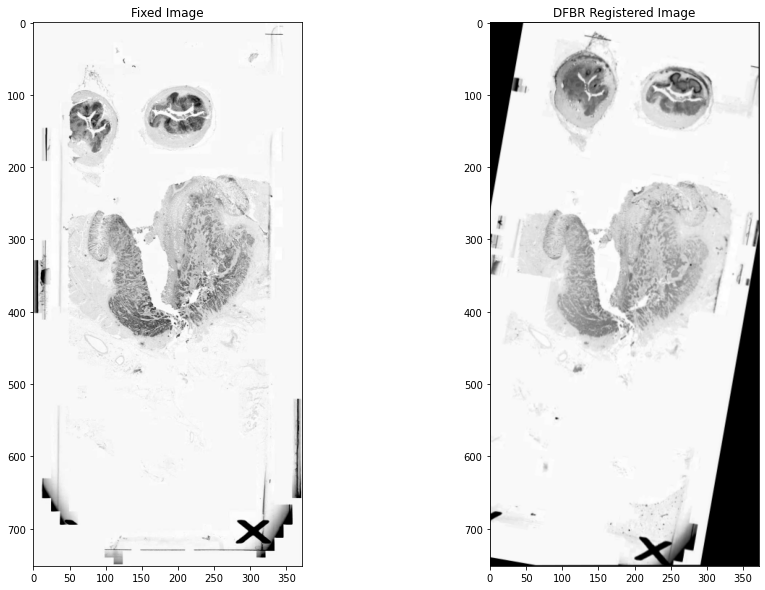

In [ ]:
from tiatoolbox.tools.registration.wsi_registration import DFBRegister

# pdb.set_trace()
# cv2.imwrite(os.path.join(main_path, 'fixed_image.png'), fixed_image)
# cv2.imwrite(os.path.join(main_path, 'moving_image.png'), pre_registered_image)
# cv2.imwrite(os.path.join(main_path, 'fixed_mask.png'), fixed_mask*255)
# cv2.imwrite(os.path.join(main_path, 'moving_mask.png'), pre_registered_mask*255)

df = DFBRegister()
dfbr_transform = df.register(fixed_image, pre_registered_image, fixed_mask, pre_registered_mask)
print(dfbr_transform)
dfbr_registered_image = cv2.warpAffine(pre_registered_image, dfbr_transform[0:-1][:], fixed_image.shape[:2][::-1]) 

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(dfbr_registered_image, cmap='gray')
axs[1].set_title("DFBR Registered Image")
plt.show()


**BSpline Transform**

  "Read: Scale > 1."



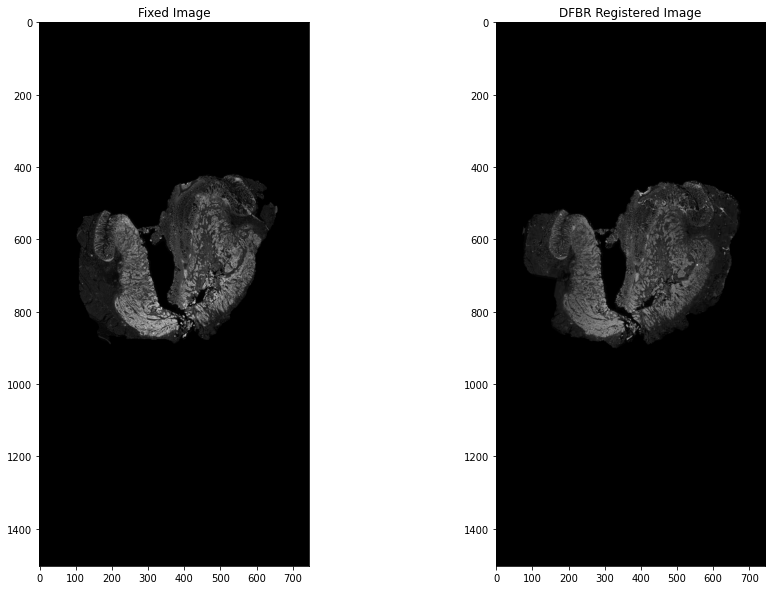

Initial Number of Parameters: 154


In [ ]:
import SimpleITK as sitk
from tiatoolbox.utils.transforms import imresize

fixed_image = fixed_wsi_reader.slide_thumbnail(resolution=0.3125, units="power")
moving_image = moving_wsi_reader.slide_thumbnail(resolution=0.3125, units="power")

fixed_image = preprocess_image(fixed_image)
moving_image = preprocess_image(moving_image)
fixed_image, moving_image = match_histograms(fixed_image, moving_image)

fixed_image = 255 - fixed_image
moving_image = 255 - moving_image
# pdb.set_trace()

fixed_mask = imresize(fixed_mask, output_size=fixed_image.shape[:2][::-1], interpolation="nearest")
moving_mask = imresize(moving_mask, output_size=moving_image.shape[:2][::-1], interpolation="nearest")
fixed_mask = np.array(fixed_mask != 0, dtype=np.uint8)
moving_mask = np.array(moving_mask != 0, dtype=np.uint8)
fixed_image = cv2.bitwise_and(fixed_image, fixed_image, mask=fixed_mask)
moving_image = cv2.bitwise_and(moving_image, moving_image, mask=moving_mask)

# apply previously computed transformations at resolution 0.3125
rigid_transform = np.matmul(dfbr_transform, pre_transform) * [[1, 1, 2], [1, 1, 2], [0, 0, 1]] 
rigid_transform_output = cv2.warpAffine(moving_image, rigid_transform[0:-1][:], fixed_image.shape[:2][::-1]) 
_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(rigid_transform_output, cmap='gray')
axs[1].set_title("DFBR Registered Image")
plt.show()


fixed_image_sitk = sitk.GetImageFromArray(fixed_image)
moving_image_sitk = sitk.GetImageFromArray(rigid_transform_output)
fixed_image_sitk = sitk.Cast(fixed_image_sitk, sitk.sitkFloat32)
moving_image_sitk = sitk.Cast(moving_image_sitk, sitk.sitkFloat32)

# Determine the number of BSpline control points using the physical 
# spacing we want for the finest resolution control grid. 
grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 20mm
image_physical_size = [size*spacing for size,spacing in zip(fixed_image_sitk.GetSize(), fixed_image_sitk.GetSpacing())]
mesh_size = [int(image_size/grid_spacing + 0.5) \
             for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]
# The starting mesh size will be 1/4 of the original, it will be refined by 
# the multi-resolution framework.
mesh_size = [int(sz/4 + 0.5) for sz in mesh_size]
# pdb.set_trace()
# mesh_size=[2]*fixed_image_sitk.GetDimension()
tx = sitk.BSplineTransformInitializer(image1=fixed_image_sitk, transformDomainMeshSize=mesh_size, order=3)
print("Initial Number of Parameters: {0}".format(tx.GetNumberOfParameters()))

R = sitk.ImageRegistrationMethod()
R.SetInitialTransformAsBSpline(tx, inPlace=True, scaleFactors=[1,2,4])
# R.SetMetricAsJointHistogramMutualInformation()
R.SetMetricAsCorrelation()
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.01)

R.SetShrinkFactorsPerLevel([4,2,1])
R.SetSmoothingSigmasPerLevel([2,1,0])
# R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
R.SetOptimizerAsGradientDescentLineSearch(5.0, 100, convergenceMinimumValue=1e-4, convergenceWindowSize=5)
# R.SetOptimizerAsLBFGS2(solutionAccuracy=1e-2, numberOfIterations=100, deltaConvergenceTolerance=0.01)
R.SetInterpolator(sitk.sitkLinear)
outTx = R.Execute(fixed_image_sitk, moving_image_sitk)

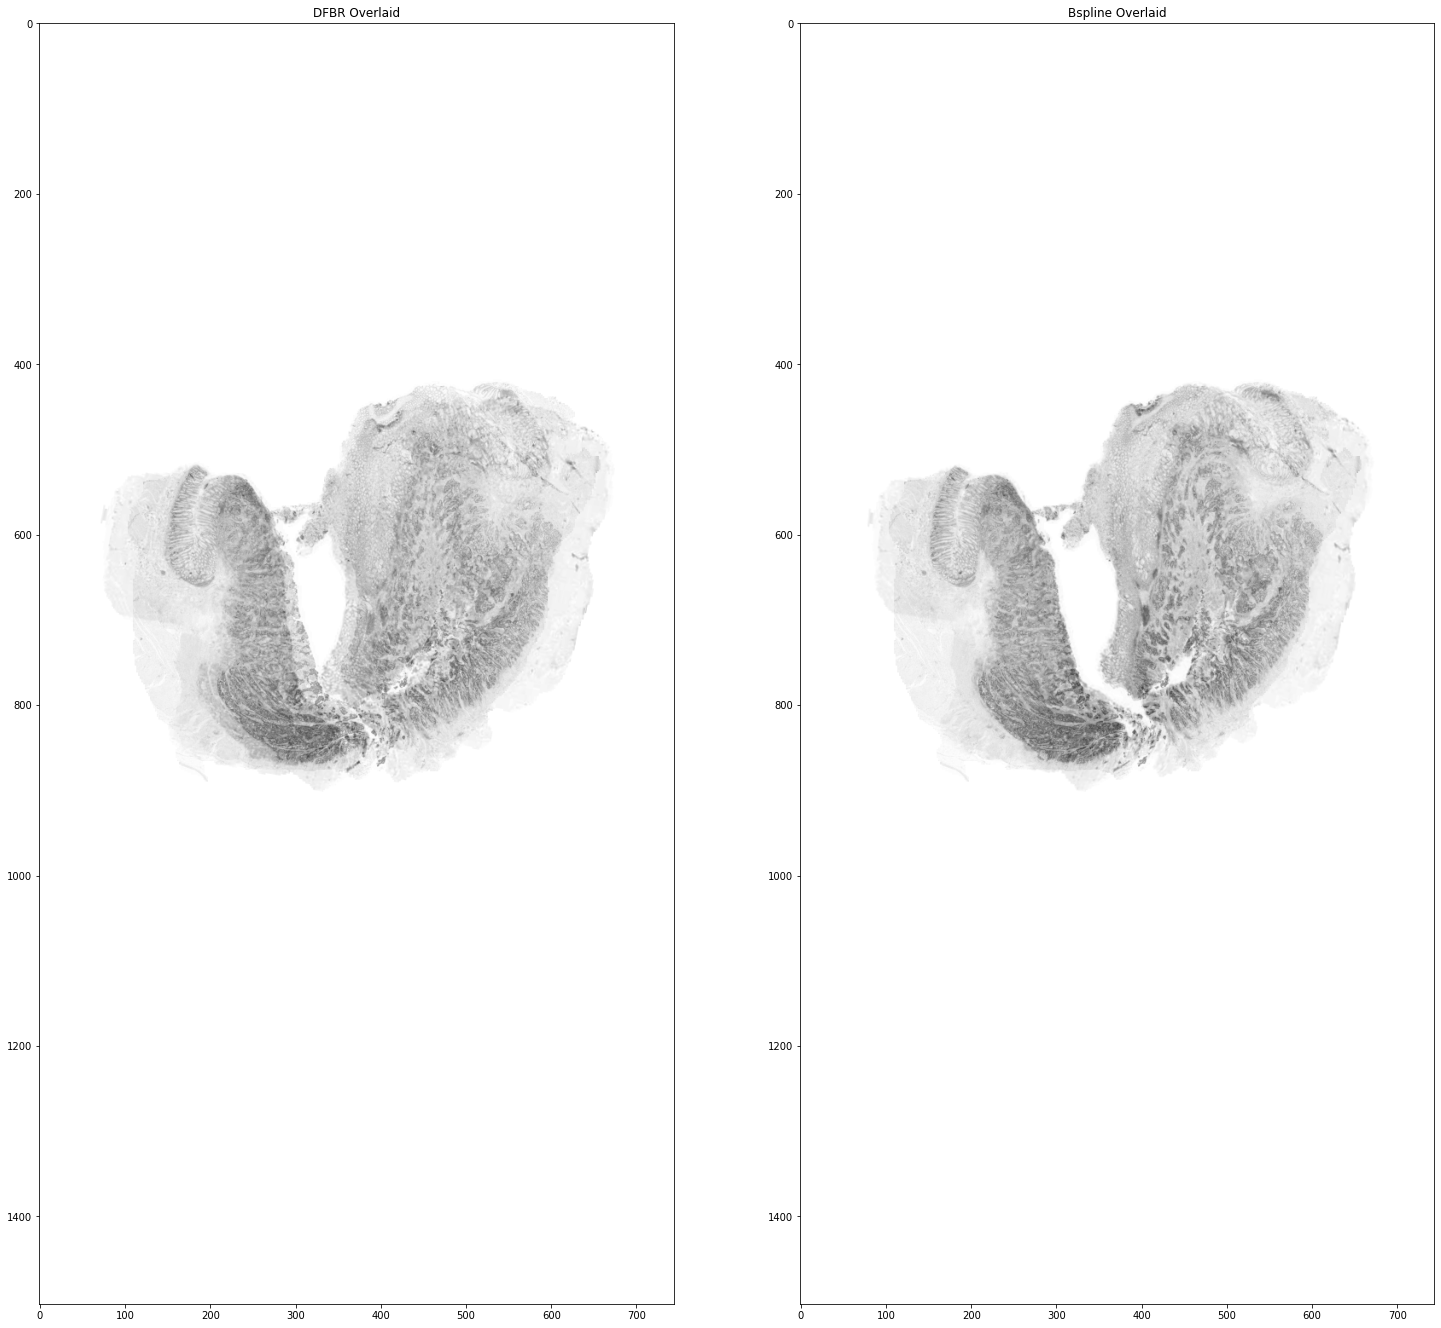

In [ ]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image_sitk)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

registered_moving = resampler.Execute(moving_image_sitk)
registered_moving = sitk.GetArrayFromImage(registered_moving)
moving = sitk.GetArrayFromImage(moving_image_sitk)

_, axs = plt.subplots(1, 2, figsize=(25,50))
axs[0].imshow(255 - moving, cmap='gray')
axs[0].imshow(255 - fixed_image, alpha=0.5, cmap='gray')
axs[0].set_title("DFBR Overlaid")
axs[1].imshow(255 - registered_moving, cmap='gray')
axs[1].imshow(255 - fixed_image, alpha=0.5, cmap='gray')
axs[1].set_title("Bspline Overlaid")
plt.show()

[-208.56071 -206.29063 -201.78337 ...  197.15659  201.44965  205.59589]


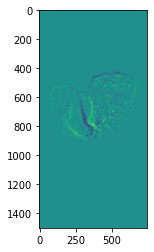

In [ ]:
diff_img = moving - registered_moving
print(np.unique(diff_img))
plt.imshow(diff_img)
plt.show()